## Imports


In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import contextily as ctx
import shapely as shp
from shapely.plotting import plot_points, plot_line, plot_polygon

from matplotlib import rcParams

rcParams["font.sans-serif"] = "Arial"
rcParams["font.family"] = "Arial"
rcParams["figure.dpi"] = 100

In [3]:
file_path = "/home/mcastro/Documents/visual_studio_code_files/geopandas-dataviz/"

## Diagrama - Pontos, Linhas e Polígonos


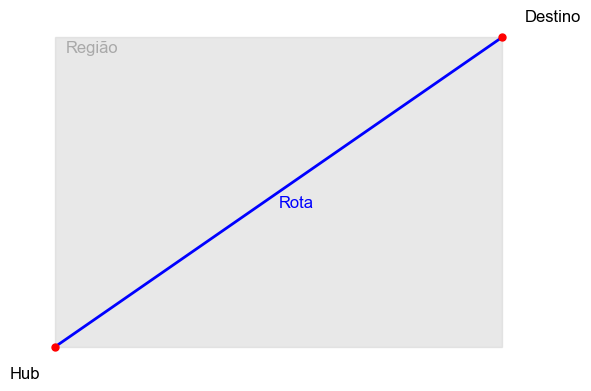

In [4]:
# Figura e eixos
fig, ax = plt.subplots(figsize=(6, 4), layout="tight")

# Pontos, linha e área
hub_point = shp.geometry.Point(0, 0)
destination_point = shp.geometry.Point(2, 2)
line = shp.geometry.LineString([(0, 0), (2, 2)])
area = shp.geometry.Polygon([(0, 0), (2, 0), (2, 2), (0, 2)])

# Plotando os elementos
plot_points(
    shp.geometry.MultiPoint([hub_point, destination_point]),
    ax=ax,
    color="red",
    markersize=5,
)
plot_polygon(area, ax=ax, add_points=False, color="lightgray", alpha=0.5)
plot_line(line, ax=ax, add_points=False, color="blue", linewidth=2)

# Anotações
ax.annotate("Rota", xy=(1, 1), xytext=(1, 0.9), fontsize=12, color="blue")
ax.annotate("Região", xy=(0.05, 1.9), fontsize=12, color="darkgray")
ax.annotate("Hub", xy=(0, 0), xytext=(-0.2, -0.2), fontsize=12, color="black")
ax.annotate("Destino", xy=(2, 2), xytext=(2.1, 2.1), fontsize=12, color="black")

# Configurações do gráfico
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.set_axis_off()
plt.show()

## Obtendo dados OSMnx


### Baixando dados de redes de ruas/vias


In [5]:
# Define o nome do local para o qual você deseja obter a rede de ruas
place_name = "Vila Mariana, São Paulo"

# Baixa a rede viária do local especificado
graph = ox.graph_from_place(place_name, network_type="drive")

# Converte o grafo para GeoDataFrame
gdf = ox.graph_to_gdfs(graph, nodes=False, edges=True)

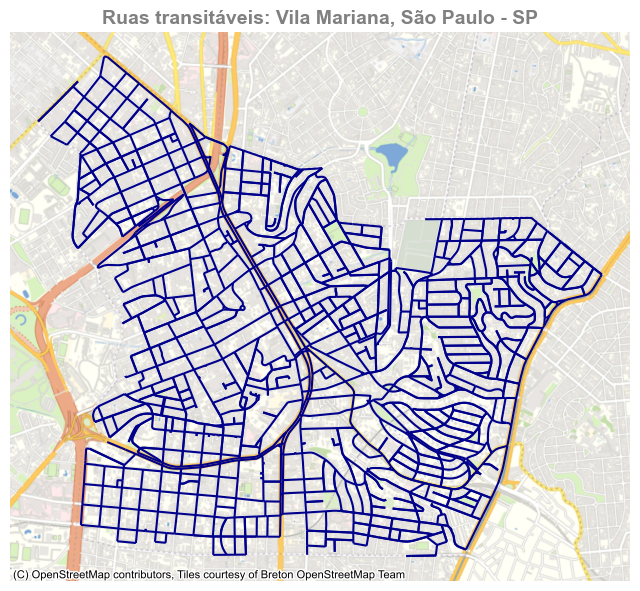

In [ ]:
# Plotando a rede viária
ax = gdf.plot(color="darkblue", figsize=(8, 8))

# Adiciona um mapa base
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.BZH)  # type: ignore

# Configurações do gráfico
ax.set_axis_off()
ax.set_title(
    f"Ruas transitáveis: {place_name} - SP",
    color="gray",
    fontsize=14,
    fontweight="bold",
)

# Salva o gráfico como imagem
output_path = file_path + "figures/1-vila_mariana_streets.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight", pad_inches=0.1)

# Exibe o gráfico
plt.show()

### Identificando hubs logísticos last-mile


In [7]:
# Cidade escolhida
place = "São Paulo, São Paulo, Brasil"

In [ ]:
# Tags para capturar hubs logísticos last-mile
tags = {
    "amenity": ["post_office", "parcel_locker"],  # Locais de entrega e coleta
    "shop": ["parcel_locker", "delivery"],  # Lojas com serviços de entrega
    "office": [
        "logistics",
        "delivery",
        "courier",
    ],  # Escritórios de logística e entrega
    "building": ["warehouse", "storage"],  # Armazéns e depósitos
    "man_made": ["warehouse"],  # Estruturas de armazenamento
}

# Baixar os dados do OpenStreetMap com base nas tags especificadas
hubs = ox.features_from_place(place, tags)  # type: ignore

# Resetar o índice do GeoDataFrame
hubs.reset_index(inplace=True)

# Manter apenas as colunas relevantes
hubs = hubs.loc[
    :,
    hubs.columns.isin(
        ["geometry", "name", "amenity", "shop", "office", "building", "man_made"]
    ),
].copy()

In [ ]:
# Verifica se a geometria é um polígono e converte para o centróide
# Isso é necessário para evitar problemas de visualização com polígonos grandes
# ou complexos, que podem não ser adequadamente representados em um mapa
hubs["geometry"] = hubs["geometry"].apply(
    lambda x: x.centroid if isinstance(x, shp.geometry.Polygon) else x  # type: ignore
)

# Garante que a geometria seja definida corretamente
hubs.set_geometry("geometry", inplace=True)

In [10]:
# Exiba as primeiras linhas do GeoDataFrame resultante
hubs.head()

,geometry,amenity,name,building,office,shop
0,POINT (-46.63611 -23.56373),post_office,Correios,NaN,NaN,NaN
1,POINT (-46.64955 -23.56848),post_office,Correios,NaN,NaN,NaN
2,POINT (-46.58667 -23.57927),post_office,Correios,NaN,NaN,NaN
3,POINT (-46.62897 -23.50314),post_office,AC Santana,NaN,NaN,NaN
4,POINT (-46.64235 -23.50288),post_office,AGF Alfredo Pujol,NaN,NaN,NaN


In [ ]:
# Unindo os dados de hubs logísticos em um formato longo
hubs_final = hubs.melt(
    id_vars="geometry",
    var_name="tag",
    value_vars=["amenity", "shop", "office", "building"],
    value_name="value",
)

# Removendo entradas sem valor
hubs_final.dropna(subset=["value"], inplace=True)

# Filtrando apenas os valores que estão na lista de tags
tag_values = []
for value in tags.values():
    tag_values.extend(value)

hubs_final = hubs_final[hubs_final["value"].isin(tag_values)]

# Resetando o índice
hubs_final.reset_index(drop=True, inplace=True)

# Exiba as primeiras linhas do GeoDataFrame final
hubs_final.head()

,geometry,tag,value
0,POINT (-46.63611 -23.56373),amenity,post_office
1,POINT (-46.64955 -23.56848),amenity,post_office
2,POINT (-46.58667 -23.57927),amenity,post_office
3,POINT (-46.62897 -23.50314),amenity,post_office
4,POINT (-46.64235 -23.50288),amenity,post_office


### Limites da cidade


In [12]:
# Obter o limite da cidade
limites_sp = ox.geocode_to_gdf(place)

limites_sp

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((-46.82627 -23.40887, -46.82623 -23.4...",-46.826269,-24.0079,-46.36509,-23.357755,414760979,relation,298285,-23.550651,-46.633382,boundary,administrative,16,0.744652,municipality,São Paulo,"São Paulo, Região Imediata de São Paulo, Regiã..."


### Plotando os pontos dos hubs logísticos e os limites da cidade


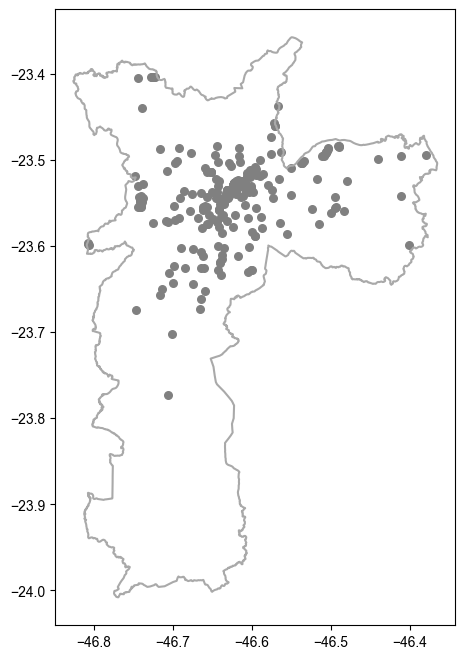

In [13]:
# Figura e eixos
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plotando o limite da cidade
limites_sp.boundary.plot(ax=ax, color="darkgray", figsize=(8, 8))

# Plotando os hubs_final logísticos
hubs_final.plot(ax=ax, color="gray", markersize=30)

# Salva o gráfico como imagem
output_path = file_path + "figures/2-hubs-cidade.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight", pad_inches=0.1)

<Axes: >

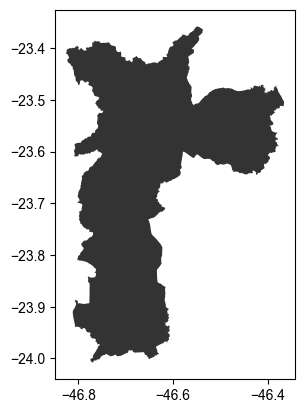

In [20]:
# Área preenchida
limites_sp.plot(color="black", alpha=0.8)

### Diferenciação de cores por categoria + mapa base


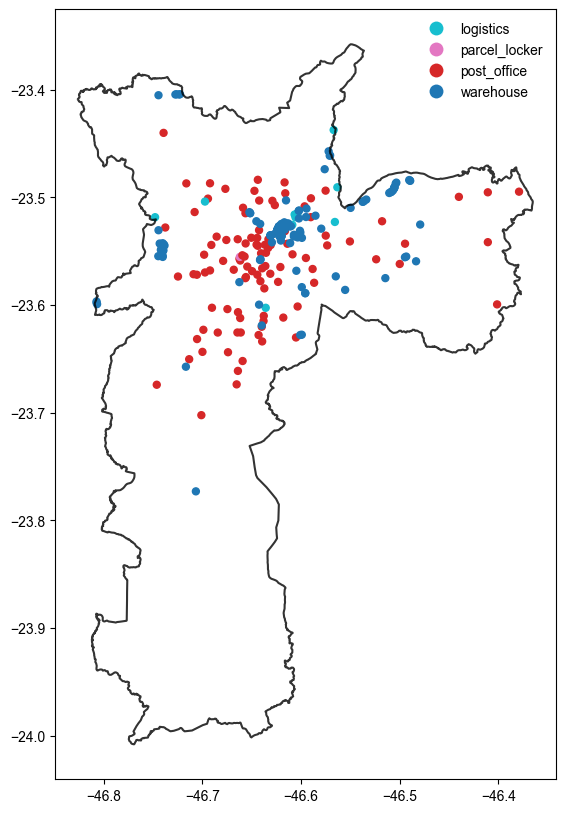

In [16]:
# Figura e eixos
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plotando os limites da cidade
limites_sp.boundary.plot(ax=ax, color="black", alpha=0.8)

# Plotando os hubs_final logísticos
hubs_final.plot(
    ax=ax,
    cmap="tab10_r",
    column="value",
    legend=True,
    legend_kwds={
        "loc": "best",
        "edgecolor": "white",
    },
    markersize=25,
)

# Salva o gráfico como imagem
output_path = file_path + "figures/3-hubs-legenda-1.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight", pad_inches=0.1)

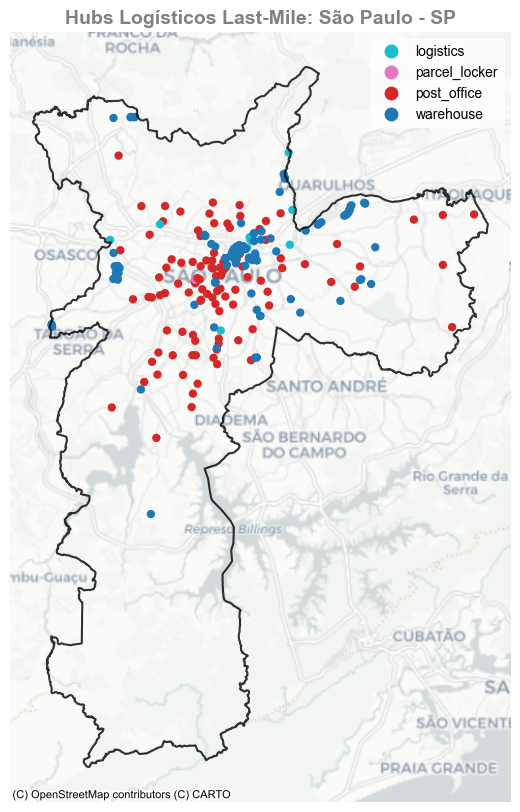

In [ ]:
# Figura e eixos
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plotando os limites da cidade
limites_sp.boundary.plot(ax=ax, color="black", alpha=0.8)

# Plotando os hubs_final logísticos
hubs_final.plot(
    ax=ax,
    cmap="tab10_r",
    column="value",
    legend=True,
    legend_kwds={
        "loc": "best",
        "edgecolor": "white",
    },
    markersize=25,
)

# Adiciona um mapa base
ctx.add_basemap(
    ax=ax,  #
    crs=limites_sp.crs.to_string(),  # type: ignore
    source=ctx.providers.CartoDB.Positron,  # type: ignore
)

# Título do gráfico
ax.set_title(
    f"Hubs Logísticos Last-Mile: São Paulo - SP",
    color="gray",
    fontsize=14,
    fontweight="bold",
)

# Configurações do gráfico
ax.set_axis_off()

# Salva o gráfico como imagem
output_path = file_path + "figures/3-hubs-legenda.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight", pad_inches=0.1)

# Exibe o gráfico
plt.show()

In [ ]:
# Contagem de hubs logísticos por tipo
hubs_final["value"].value_counts()

value
warehouse        146
post_office      103
logistics         12
parcel_locker      1
Name: count, dtype: int64

### Obter ruas principais


In [ ]:
# Obter rede viária - apenas ruas principais
roads = ox.graph_from_place(place, custom_filter='["highway"~"motorway|trunk|primary"]')

# Converter o grafo para GeoDataFrame
roads_gdf = ox.graph_to_gdfs(roads, nodes=False, edges=True)

# Resetar o índice do GeoDataFrame
roads_gdf.reset_index(inplace=True)

# Manter apenas as colunas relevantes
roads_gdf = roads_gdf.loc[:, roads_gdf.columns.isin(["geometry", "name", "highway"])]

In [360]:
roads_gdf.head()

,highway,name,geometry
0,trunk,Avenida Doutora Ruth Cardoso,"LINESTRING (-46.70223 -23.56746, -46.70228 -23..."
1,motorway,Marginal Pinheiros (Expressa),"LINESTRING (-46.69923 -23.57296, -46.69994 -23..."
2,motorway,Marginal Pinheiros (Expressa),"LINESTRING (-46.74815 -23.53462, -46.74716 -23..."
3,motorway,Marginal Pinheiros (Expressa),"LINESTRING (-46.73065 -23.54991, -46.72931 -23..."
4,trunk_link,NaN,"LINESTRING (-46.657 -23.5173, -46.65679 -23.51..."


In [ ]:
# Limpar a coluna 'highway' para manter apenas o tipo de estrada
# Exemplo: "motorway_link" -> "motorway"
roads_gdf["highway"] = roads_gdf["highway"].apply(
    lambda x: x.split("_")[0] if isinstance(x, str) else None
)

In [ ]:
# Exibir os tipos de estradas e suas contagens
roads_gdf["highway"].value_counts()

highway
primary     3866
trunk       2073
motorway     621
Name: count, dtype: int64

### Hubs logísticos + principais vias


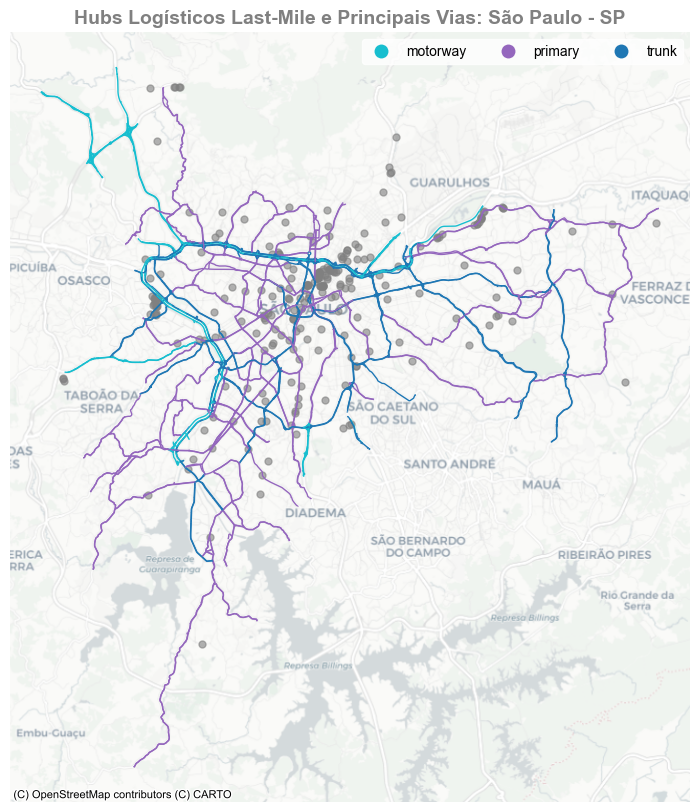

In [ ]:
# Figura e eixos
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plotando as estradas
roads_gdf.plot(
    ax=ax,
    cmap="tab10_r",
    column="highway",
    legend=True,
    legend_kwds={"loc": "best", "ncols": 3, "edgecolor": "white"},
    linewidth=1,
)

# Plotando os hubs_final logísticos
hubs_final.plot(ax=ax, color="gray", alpha=0.6, markersize=25)

# Adiciona um mapa base
ctx.add_basemap(
    ax, crs=limites_sp.crs.to_string(), source=ctx.providers.CartoDB.Positron  # type: ignore
)

# Título do gráfico
ax.set_title(
    f"Hubs Logísticos Last-Mile e Principais Vias: São Paulo - SP",
    color="gray",
    fontsize=14,
    fontweight="bold",
)

# Configurações do gráfico
ax.set_axis_off()

# Salva o gráfico como imagem
output_path = file_path + "figures/4-hubs-vias.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight", pad_inches=0.1)

# Exibe o gráfico
plt.show()

## Mapa coroplético - quantidade de hubs por bairro


In [365]:
# Carregando o shapefile dos bairros de São Paulo
path = "/home/mcastro/Documents/visual_studio_code_files/geopandas-dataviz/data/SIRGAS_SHP_distrito.shp"

# Lendo o shapefile com GeoPandas
bairros = gpd.read_file(path)

# Exiba as primeiras linhas do GeoDataFrame dos bairros
bairros.head()

,ds_codigo,ds_nome,ds_sigla,ds_areakm,ds_areamt,geometry
0,67,RIO PEQUENO,RPE,9.657,9657007.38,"POLYGON ((320567.464 7394377.312, 320581.184 7..."
1,25,CIDADE TIRADENTES,CTI,14.939,14939046.96,"POLYGON ((357428.688 7387653.528, 357433.497 7..."
2,46,JARDIM SAO LUIS,JDS,26.048,26047523.11,"POLYGON ((321618.419 7377778.152, 321559.629 7..."
3,64,PONTE RASA,PRA,6.597,6596680.61,"POLYGON ((344730.886 7398738.087, 344738.505 7..."
4,49,LIBERDADE,LIB,3.651,3651129.57,"POLYGON ((332504.515 7392094.984, 332505.952 7..."


In [ ]:
# Definir o mesmo sistema de referência de coordenadas (CRS) para bairros
bairros = bairros.set_crs("EPSG:31983", allow_override=True, inplace=True)

# Convertendo o CRS dos bairros para o CRS dos hubs_final
bairros.to_crs(hubs_final.crs.to_string(), inplace=True)  # type: ignore

In [ ]:
# Realizar a sobreposição espacial (overlay) entre os hubs logísticos e os bairros
hubs_final = hubs_final.overlay(bairros, how="intersection")

# Exiba as primeiras linhas do GeoDataFrame final após a sobreposição
hubs_final.head()

,tag,value,ds_codigo,ds_nome,ds_sigla,ds_areakm,ds_areamt,geometry
0,amenity,post_office,49,LIBERDADE,LIB,3.651,3651129.57,POINT (-46.63611 -23.56373)
1,amenity,post_office,90,VILA MARIANA,VMN,8.598,8597789.80,POINT (-46.64955 -23.56848)
2,amenity,post_office,93,VILA PRUDENTE,VPR,9.525,9525461.96,POINT (-46.58667 -23.57927)
3,amenity,post_office,70,SANTANA,STN,13.092,13091744.80,POINT (-46.62897 -23.50314)
4,amenity,post_office,70,SANTANA,STN,13.092,13091744.80,POINT (-46.64235 -23.50288)


In [ ]:
# Obter a contagem de hubs logísticos por bairro
qtd_hubs = hubs_final.groupby("ds_codigo", as_index=False).size()

# Unir a contagem de hubs logísticos com o GeoDataFrame dos bairros
bairros_final = bairros.merge(qtd_hubs, on="ds_codigo", how="left")

# Substituir valores NaN por 0 (bairros sem hubs logísticos)
bairros_final.fillna(0, inplace=True)

# Mostrar as primeiras linhas do GeoDataFrame final dos bairros com a contagem de hubs
bairros_final.head()

,ds_codigo,ds_nome,ds_sigla,ds_areakm,ds_areamt,geometry,size
0,67,RIO PEQUENO,RPE,9.657,9657007.38,"POLYGON ((-46.75791 -23.55105, -46.75778 -23.5...",0.0
1,25,CIDADE TIRADENTES,CTI,14.939,14939046.96,"POLYGON ((-46.39751 -23.61543, -46.39746 -23.6...",1.0
2,46,JARDIM SAO LUIS,JDS,26.048,26047523.11,"POLYGON ((-46.7496 -23.70103, -46.75018 -23.70...",1.0
3,64,PONTE RASA,PRA,6.597,6596680.61,"POLYGON ((-46.52079 -23.51417, -46.52072 -23.5...",1.0
4,49,LIBERDADE,LIB,3.651,3651129.57,"POLYGON ((-46.64125 -23.57293, -46.64124 -23.5...",3.0


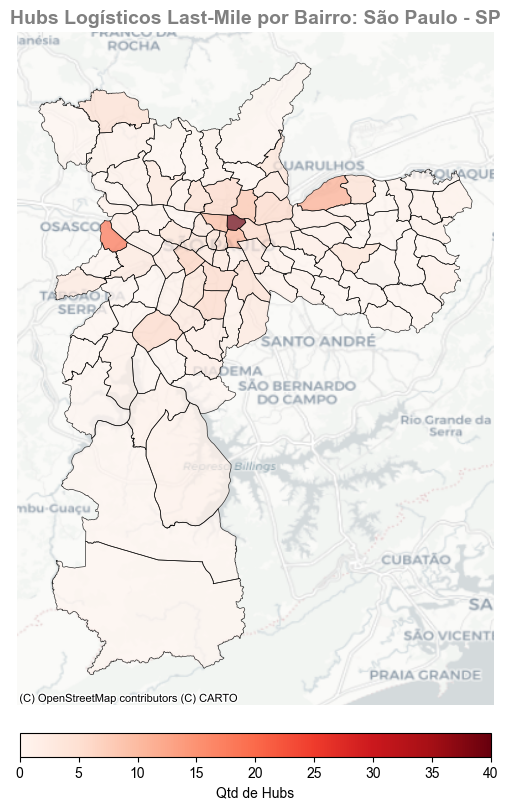

In [369]:
# Figura e eixos
fig, ax = plt.subplots(1, 1, layout="constrained", figsize=(10, 8))

# Limites dos bairros
bairros.boundary.plot(ax=ax, color="black", alpha=0.8, linewidth=0.5)

# Plotando os bairros com a contagem de hubs logísticos - choropleth map
bairros_final.plot(
    ax=ax,
    column="size",
    cmap="Reds",
    legend=True,
    legend_kwds={
        "label": "Qtd de Hubs",
        "location": "bottom",
        "orientation": "horizontal",
        "fraction": 0.035,
        "pad": 0.04,
    },
    alpha=0.7,
)

# Manter a proporção correta do mapa
ax.set_aspect(1)

# Adiciona um mapa base
ctx.add_basemap(
    ax, crs=hubs_final.crs.to_string(), source=ctx.providers.CartoDB.Positron  # type: ignore
)

# Título do gráfico
ax.set_title(
    f"Hubs Logísticos Last-Mile por Bairro: São Paulo - SP",
    color="gray",
    fontsize=14,
    fontweight="bold",
)

# Configurações do gráfico
ax.set_axis_off()

# Salva o gráfico como imagem
output_path = file_path + "figures/5-hubs-cmap.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight", pad_inches=0.1)

# Exibe o gráfico
plt.show()